# Estudo da associação entre a declaração de raça e acesso à educação superior a partir dos resultados da PNAD Contínua (painel 6)

[Marcelo Pereira](https://github.com/tbmpereira), outubro de 2020

O presente estudo faz parte do artigo entregue para conclusão da disciplina "Sociologia das Desigualdades e da Estratificação", do Programa de Pós-Graduação em Sociologia da Universidade Federal de Minas Gerais, cursada por mim no primeiro semestre de 2020.

In [1]:
import pnadc
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
from scipy.stats import chi2

O [módulo pnadc](https://github.com/ppnasser/pnadc/), criado por Patrick Nasser, importa a rodada trimestral da PNADC e retorna um DataFrame do Pandas. Verificamos que o kernel do Python morre ao importar grandes séries temporais, por problema de memória RAM. Desta maneira, propomos importar cada rodada da PNAD separadamente, filtrar apenas as variáveis de interesse (características gerais do entrevistado e escolaridade), e exportar o 'csv', para posteriormente concatenar os dados.

In [85]:
#gerando tuplas para cada trimestre a ser importado
trimestres = []
for ano in range(2017, 2020):
    for trimestre in range(1, 5):
        trimestres.append((trimestre, ano))

In [ ]:
#criando um laço para importar o dataset de cada trimestre, selecionar as variáveis de interesse e exportar num arquivo csv
for tupla in trimestres:
    df = pnadc.get(tupla[0], tupla[1])
    df = df[['Ano', 'Trimestre', 'UF', 'Capital', 'RM_RIDE', 'UPA', 'Estrato', 'V1008', 'V1014', 'V1016', 'V1022', 'V1023', 'V1027', 'V1028', 
             'V1029', 'posest', 'V2001', 'V2003', 'V2005', 'V2007', 'V2008', 'V20081', 'V20082', 'V2009', 'V2010', 'V3001', 'V3002', 'V3002A', 'V3003', 'V3003A', 'V3007']]
    df = pnadc.tools.identify(df)
    df.to_csv('pnadc_{}-{}.csv'.format(tupla[1], tupla[0]), index=False)

In [ ]:
#concatenar todos os datasets
arquivos = ['pnadc_{}-{}.csv'.format(tupla[1], tupla[0]) for tupla in trimestres]
pnadcs = pd.concat([pd.read_csv(arquivo) for arquivo in arquivos])

In [ ]:
#alterar o tipo das variáveis para salvar memória
for var in pnadcs.columns[:-3]:
    try:
        pnadcs[var] = pnadcs[var].astype('int32')
    except:
        pnadcs[var] = pnadcs[var].astype('float32')

In [ ]:
#exportando o dataset concatenado
pnadcs.to_csv('pnadc_2017-2019.csv', index=False)

In [ ]:
df_chunck = pd.read_csv('pnadc_2017-2019.csv', index_col=False, chunksize=500000)

In [ ]:
def chunk_processing(chunk):
    for var in chunk.columns:
        try:
            chunk[var] = chunk[var].astype('int32')
        except:
            try:
                chunk[var] = chunk[var].astype('float32')
            except:
                continue
    return chunk

chunk_list = []

for chunk in df_chunck:
    chunk_filtered = chunk_processing(chunk)
    chunk_list.append(chunk)

painel6 = pd.concat(chunk_list)

Filtros: Ignorar registros de data de nascimento '9999', Apenas painel 6, descartar variável 'keyDorm'

In [ ]:
painel6.drop('keyDom', axis=1, inplace=True)
painel6 = painel6[painel6.V1014 == 6]
painel6 = painel6[painel6.V20082 != 9999]

In [ ]:
painel6.to_csv('painel6.csv')

Filtrar, de acordo com o algoritmo proposto por [Ribas e Soares (2008)](https://www.ipea.gov.br/portal/index.php?option=com_content&view=article&id=4605), indivíduos (variável keyIden) que tenha data de nascimento e sexo iguais (variáveis V2007, V2008, V20081 e V20082)

In [3]:
check_V20007 = painel6.groupby('keyInd').V2007.nunique().eq(1)
check_V20008 = painel6.groupby('keyInd').V2008.nunique().eq(1)
check_V200081 = painel6.groupby('keyInd').V20081.nunique().eq(1)
check_V200082 = painel6.groupby('keyInd').V20082.nunique().eq(1)

In [4]:
keyInd = painel6.keyInd.unique()

In [5]:
keyInd_V2007 = keyInd[check_V20007.values]
keyInd_V2008 = keyInd[check_V20008.values]
keyInd_V20081 = keyInd[check_V200081.values]
keyInd_V20082 = keyInd[check_V200082.values]

In [6]:
intersect = np.intersect1d(keyInd_V2007, keyInd_V2008)
intersect = np.intersect1d(intersect, keyInd_V20081)
intersect = np.intersect1d(intersect, keyInd_V20082)

In [7]:
mask = painel6.keyInd.isin(intersect)
painel6_filtrado = painel6[mask]

In [ ]:
painel6_filtrado.to_csv('painel6_filtrado.csv', index=False)

In [2]:
painel6_filtrado = pd.read_csv('painel6_filtrado.csv', index_col=False)

Explorando os dados sobre declaração de cor ou raça

In [3]:
# número expressivo de respondentes mudaram a declaração de cor ou raça
mudou = painel6_filtrado[['keyInd', 'V2010']].groupby('keyInd').nunique().eq(1)

In [4]:
lista_mudou = painel6_filtrado.keyInd.unique()[mudou.V2010.values]
mask_mudou = painel6_filtrado.keyInd.isin(lista_mudou)
painel6_mudou = painel6_filtrado[~mask_mudou]

True = não mudou; False = mudou a declaração de cor ou raça em ao menos uma das rodadas do painel

In [15]:
df_mudou = pd.DataFrame(mudou.value_counts())
df_mudou.columns = ['valor']
mudou_percent = df_mudou.values / painel6_filtrado.keyInd.nunique()
df_mudou['percent'] = mudou_percent
df_mudou

,valor,percent
V2010,,
True,350038,0.685894
False,160300,0.314106


Calculando os totais de raça por rodada do painel

In [211]:
raca_por_rodada = painel6_filtrado.groupby(['V1016', 'V2010'])['keyInd'].count()

In [212]:
raca_por_rodada.index.set_levels([[1, 2, 3, 4, 5], ['branca', 'preta', 'amarela', 'parda', 'indígena', 'ignorado']], inplace=True)

In [213]:
raca_por_rodada

V1016  V2010   
1      branca      173622
       preta        33532
       amarela       1789
       parda       213551
       indígena      1693
       ignorado        31
2      branca      174458
       preta        32617
       amarela       1747
       parda       217217
       indígena      1615
       ignorado        16
3      branca      173203
       preta        33027
       amarela       1912
       parda       217456
       indígena      1647
       ignorado        13
4      branca      171449
       preta        33204
       amarela       2016
       parda       216902
       indígena      1749
       ignorado         7
5      branca      168260
       preta        33231
       amarela       2094
       parda       214707
       indígena      1758
       ignorado         9
Name: keyInd, dtype: int64

In [171]:
raca_por_rodada.to_csv('raca_por_rodada.csv')

In [214]:
branca = raca_por_rodada.reset_index()[raca_por_rodada.reset_index()['V2010'] == 'branca']['keyInd'].to_list()
preta = raca_por_rodada.reset_index()[raca_por_rodada.reset_index()['V2010'] == 'preta']['keyInd'].to_list()
amarela = raca_por_rodada.reset_index()[raca_por_rodada.reset_index()['V2010'] == 'amarela']['keyInd'].to_list()
parda = raca_por_rodada.reset_index()[raca_por_rodada.reset_index()['V2010'] == 'parda']['keyInd'].to_list()
indigena = raca_por_rodada.reset_index()[raca_por_rodada.reset_index()['V2010'] == 'indígena']['keyInd'].to_list()

<IPython.core.display.Javascript object>


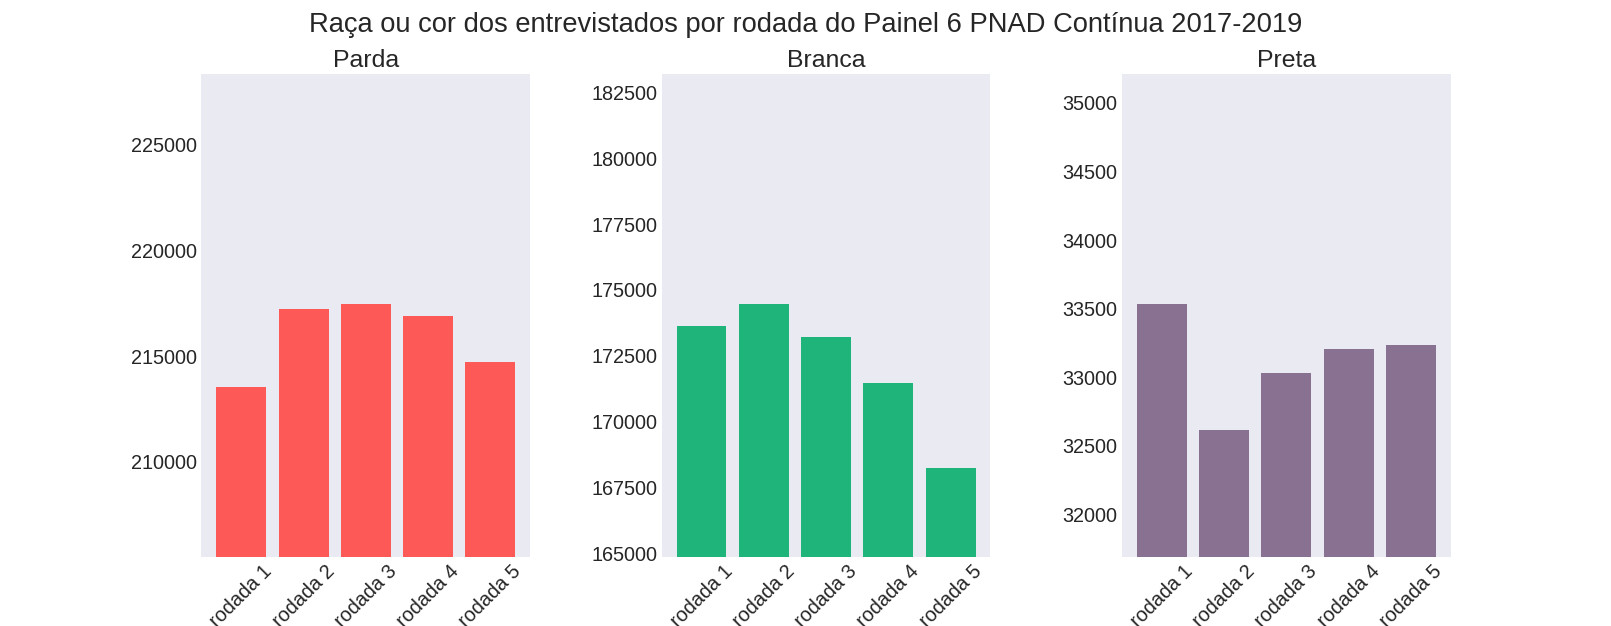

In [239]:
%matplotlib notebook
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.style.use('seaborn-dark')
fig, ax = plt.subplots(1, 3, figsize=(18, 7))
fig.suptitle('Raça ou cor dos entrevistados por rodada do Painel 6 PNAD Contínua 2017-2019', fontsize=22)
ax[0].bar(np.arange(1, 6), parda, color='xkcd:grapefruit')
ax[0].set_title('Parda', fontsize=20)
ax[1].bar(np.arange(1, 6), branca, color='#1fb57a')
ax[1].set_title('Branca', fontsize=20)
ax[2].bar(np.arange(1, 6), preta, color='#887191')
ax[2].set_title('Preta', fontsize=20)
for axis in ax:
    axis.set_xticks(np.arange(1, 6))
    axis.set_xticklabels(['rodada 1', 'rodada 2', 'rodada 3', 'rodada 4', 'rodada 5'])
    axis.tick_params(axis='x',labelsize=16, rotation=45)
    axis.tick_params(axis='y',labelsize=16)
    a, b = axis.get_ylim()
    axis.set_ylim(9*b/10, b)
plt.subplots_adjust(wspace = 0.4)


Vamos criar lista com as observações da variável "cor ou raça" V2010 e filtrar apenas os indivíduos com 5 observações (participaram das 5 rodadas da PNAD Contínua painel 6)

In [5]:
def cria_lista(s):
    return s.to_list()
tipos_mudanca = painel6_mudou.groupby('keyInd').V2010.apply(cria_lista)

In [7]:
tipos_mudanca = tipos_mudanca[tipos_mudanca.map(len) == 5]

In [22]:
#mostrando os 50 primeiros maiores resultados que mostram a grande variedade de situações existentes
tipos_mudanca.value_counts()[:50]

TypeError: unhashable type: 'list'

Exception ignored in: 'pandas._libs.index.IndexEngine._call_map_locations'
Traceback (most recent call last):
  File "pandas/_libs/hashtable_class_helper.pxi", line 1709, in pandas._libs.hashtable.PyObjectHashTable.map_locations
TypeError: unhashable type: 'list'


[1, 4, 4, 4, 4]    6117
[4, 1, 4, 4, 4]    5128
[1, 1, 1, 1, 4]    4988
[4, 4, 4, 4, 1]    4758
[4, 1, 1, 1, 1]    4673
[4, 4, 1, 4, 4]    4535
[4, 4, 4, 1, 4]    4210
[1, 4, 1, 1, 1]    4009
[1, 1, 4, 1, 1]    3928
[1, 1, 1, 4, 1]    3844
[2, 4, 4, 4, 4]    3595
[4, 4, 4, 4, 2]    3150
[4, 2, 4, 4, 4]    2774
[1, 1, 4, 4, 4]    2710
[1, 4]             2687
[4, 4, 4, 2, 4]    2676
[4, 4, 2, 4, 4]    2601
[1, 1, 1, 4, 4]    2492
[4, 1]             2461
[4, 4, 1, 1, 1]    2140
[4, 4, 4, 1, 1]    2135
[4, 1, 1, 4, 4]    1654
[1, 4, 1, 4, 4]    1558
[1, 1, 4, 4, 1]    1514
[1, 4, 4, 4, 1]    1465
[1, 4, 4, 1, 1]    1462
[4, 4, 1, 1, 4]    1441
[1, 1, 4, 1, 4]    1432
[4, 1, 1, 1, 4]    1412
[4, 2, 2, 2, 2]    1350
[1, 4, 4]          1347
[1, 4, 4, 4]       1310
[4, 4, 1, 4, 1]    1305
[1, 4, 4, 1, 4]    1296
[1, 4, 1, 1, 4]    1276
[4, 4, 1]          1259
[4, 1, 4, 1, 1]    1250
[4, 1, 4, 1, 4]    1233
[1, 1, 4]          1219
[4, 1, 4, 4, 1]    1210
[2, 2, 2, 2, 4]    1202
[4, 4, 4, 1]    

Percebemos uma grande diversidade de situações, mas a maioria das observações são combinações da cor branca (1), parda (4) e preta (2). Dessa maneira, consideraremos a primeira e a última observação (declaração inicial e final). Será notável um grande peso do grupo "outros", que se dá em parte pelas pessoas que, apesar de terem alterado sua declaração de raça durante o painel, declaram a mesma raça na primeira e última rodada.

In [6]:
def como_mudou(a):
    if a[0] == 1 and a[-1] == 4:
        return 1
    elif a[0] == 4 and a[-1] == 1:
        return 2
    elif a[0] == 2 and a[-1] == 4:
        return 3
    elif a[0] == 4 and a[-1] == 2:
        return 4
    elif a[0] == 1 and a[-1] == 2:
        return 5
    elif a[0] == 2 and a[-1] == 1:
        return 6
    else:
        return 7

legenda 1 = branco para pardo; 2 = pardo para branco; 3 = preto para pardo; 4 = pardo para preto; 5 = branco para preto; 6 = preto para branco; 7 = outros

In [12]:
como = tipos_mudanca.apply(como_mudou)
como

keyInd
110000016.01.06.01.0     2
110000016.010.06.01.0    2
110000016.010.06.02.0    2
110000016.010.06.03.0    2
110000016.010.06.04.0    2
                        ..
530051067.04.06.01.0     2
530051067.05.06.04.0     3
530051067.05.06.05.0     7
530051067.08.06.02.0     2
530051067.09.06.01.0     2
Name: V2010, Length: 160300, dtype: int64

In [106]:
como.value_counts().to_csv('tipos_mudanca.csv')

Gerando tabelas e visualizações das mudanças de declaração de raça ou cor por sexo e por faixa etária

In [27]:
como_mudou = pd.DataFrame(como).reset_index().merge(painel6_mudou[['keyInd', 'V2007', 'V2009']].groupby('keyInd').max(), how='left', on='keyInd')

In [29]:
como_mudou.groupby('V2007')['V2010'].value_counts()

V2007  V2010
1      7        35588
       1        15573
       2        13271
       3         6833
       4         6492
       5          555
       6          549
2      7        37153
       1        16117
       2        14203
       3         6487
       4         6289
       5          632
       6          558
Name: V2010, dtype: int64

In [30]:
como_mudou.groupby('V2007')['V2010'].value_counts().to_csv('como_mudou_sexo.csv')

In [45]:
def faixa_etaria(idade):
    if idade < 18:
        return 1
    elif idade >= 18 and idade <= 22:
        return 2
    elif idade > 22 and idade < 35:
        return 3
    elif idade >= 35 and idade < 60:
        return 4
    return 5

In [47]:
como_mudou['faixa_etaria'] = como_mudou.V2009.apply(faixa_etaria)
como_mudou.groupby('faixa_etaria')['V2010'].value_counts()

faixa_etaria  V2010
1             7        17542
              1         9470
              2         7661
              4         3008
              3         2805
              5          260
              6          211
2             7         5400
              1         2439
              2         2221
              4         1053
              3         1033
              5           82
              6           77
3             7        11929
              1         5052
              2         4574
              3         2527
              4         2216
              5          199
              6          196
4             7        25790
              1         9894
              2         8759
              3         4873
              4         4485
              5          450
              6          421
5             7        12080
              1         4835
              2         4259
              3         2082
              4         2019
              6        

In [50]:
faixa_etaria = como_mudou.groupby('faixa_etaria')['V2010'].value_counts()
faixa_etaria.index.set_names(['faixa_etaria', 'como_mudou'], inplace=True)
faixa_etaria = pd.DataFrame(faixa_etaria).reset_index()

<IPython.core.display.Javascript object>


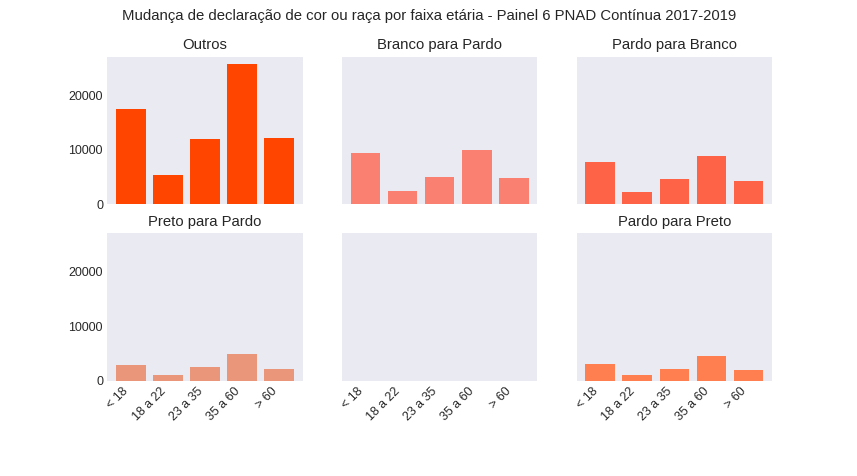

In [240]:
%matplotlib notebook
outros = faixa_etaria[faixa_etaria.como_mudou == 7]['V2010']
branco_pardo = faixa_etaria[faixa_etaria.como_mudou == 1]['V2010']
pardo_branco = faixa_etaria[faixa_etaria.como_mudou == 2]['V2010']
preto_pardo = faixa_etaria[faixa_etaria.como_mudou == 3]['V2010']
pardo_preto = faixa_etaria[faixa_etaria.como_mudou == 4]['V2010']

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.style.use('seaborn-dark')
fig, ax = plt.subplots(2,3, sharey=True, sharex=True)
fig.suptitle('Mudança de declaração de cor ou raça por faixa etária - Painel 6 PNAD Contínua 2017-2019')
ax[0][0].bar(np.arange(1, 6), outros, color='orangered', label='Outros')
ax[0][0].set_title('Outros')
ax[0][1].bar(np.arange(1, 6), branco_pardo, color='salmon', label='branca')
ax[0][1].set_title('Branco para Pardo')
ax[0][2].bar(np.arange(1, 6), pardo_branco, color='tomato', label='preta')
ax[0][2].set_title('Pardo para Branco')
ax[1][0].bar(np.arange(1, 6), preto_pardo, color='darksalmon', label='branca')
ax[1][0].set_title('Preto para Pardo')
ax[1][2].bar(np.arange(1, 6), pardo_preto, color='coral', label='preta')
ax[1][2].set_title('Pardo para Preto')
#ax.plot(np.arange(1, 6), amarela, color='y')
#ax.plot(np.arange(1, 6), indigena, color='g')
for row in ax:
    for axis in row:
        axis.set_xticks(np.arange(1, 6))
        axis.set_xticklabels(['< 18', '18 a 22', '23 a 35', '35 a 60', '> 60'])
#         axis.tick_params(axis='x', rotation=45)
# plt.subplots_adjust(hspace=0.5)
fig.autofmt_xdate(rotation=45)
#     a, b = axis.get_ylim()
#     axis.set_ylim(4*b/5, b)
#     axis.get_yaxis().set_major_formatter(FuncFormatter(lambda x, p: format(int(x), '.')))

<IPython.core.display.Javascript object>


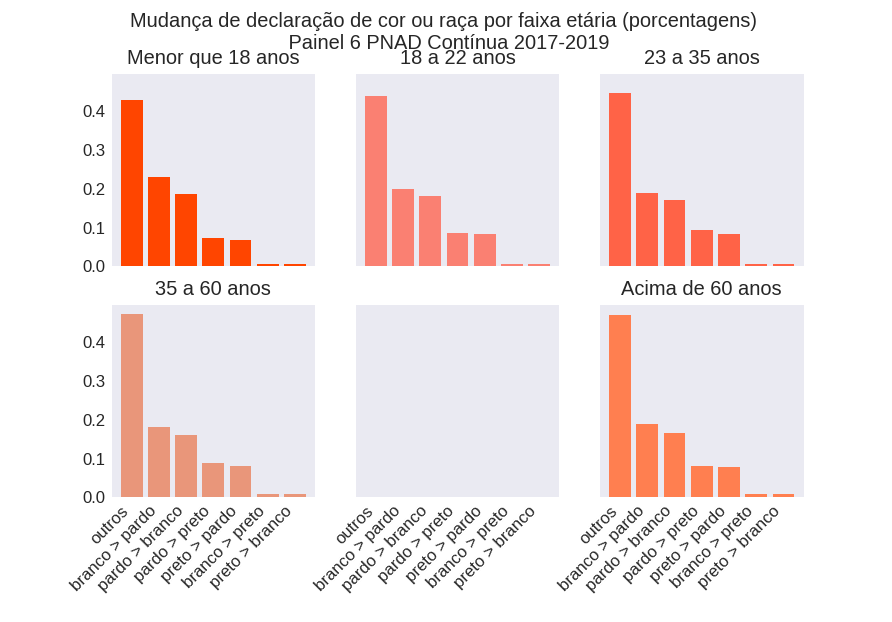

In [241]:
%matplotlib notebook
menos18 = faixa_etaria[faixa_etaria.faixa_etaria == 1]['V2010'] / faixa_etaria[faixa_etaria.faixa_etaria == 1]['V2010'].sum()
entre18_22 = faixa_etaria[faixa_etaria.faixa_etaria == 2]['V2010'] / faixa_etaria[faixa_etaria.faixa_etaria == 2]['V2010'].sum()
entre23_35 = faixa_etaria[faixa_etaria.faixa_etaria == 3]['V2010'] / faixa_etaria[faixa_etaria.faixa_etaria == 3]['V2010'].sum()
entre35_60 = faixa_etaria[faixa_etaria.faixa_etaria == 4]['V2010'] / faixa_etaria[faixa_etaria.faixa_etaria == 4]['V2010'].sum()
acima60 = faixa_etaria[faixa_etaria.faixa_etaria == 5]['V2010']  / faixa_etaria[faixa_etaria.faixa_etaria == 5]['V2010'].sum()

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
plt.style.use('seaborn-dark')
fig, ax = plt.subplots(2,3, sharey=True, sharex=True)
fig.suptitle('Mudança de declaração de cor ou raça por faixa etária (porcentagens) \n Painel 6 PNAD Contínua 2017-2019')
ax[0][0].bar(np.arange(1, 8), menos18, color='orangered', label='Outros')
ax[0][0].set_title('Menor que 18 anos')
ax[0][1].bar(np.arange(1, 8), entre18_22, color='salmon', label='branca')
ax[0][1].set_title('18 a 22 anos')
ax[0][2].bar(np.arange(1, 8), entre23_35, color='tomato', label='preta')
ax[0][2].set_title('23 a 35 anos')
ax[1][0].bar(np.arange(1, 8), entre35_60, color='darksalmon', label='branca')
ax[1][0].set_title('35 a 60 anos')
ax[1][2].bar(np.arange(1, 8), acima60, color='coral', label='preta')
ax[1][2].set_title('Acima de 60 anos')
#ax.plot(np.arange(1, 6), amarela, color='y')
#ax.plot(np.arange(1, 6), indigena, color='g')
for row in ax:
    for axis in row:
        axis.set_xticks(np.arange(1, 8))
        axis.set_xticklabels(['outros', 'branco > pardo', 'pardo > branco', 'pardo > preto',
                              'preto > pardo', 'branco > preto', 'preto > branco'])
#         axis.tick_params(axis='x', rotation=75)
fig.autofmt_xdate(rotation=45)


In [48]:
como_mudou.groupby('faixa_etaria')['V2010'].value_counts().to_csv('como_mudou_faixa_etaria.csv')

In [24]:
t = tipos_mudanca.apply(como_mudou).value_counts()

In [26]:
#total de observações
tipos_mudanca.shape[0]

160300

In [25]:
pd.DataFrame({'contagem':t.values, 'percentagem':t.values / tipos_mudanca.shape[0]}, index=t.index)

,contagem,percentagem
7,72741,0.453780
1,31690,0.197692
2,27474,0.171391
3,13320,0.083094
4,12781,0.079732
5,1187,0.007405
6,1107,0.006906


Analisando o acesso ao ensino superior da amostra por raça. Consideraremos indivíduos entre 18 e 22 anos (idade esperada do início do ensino superior)

In [130]:
idade_facul = painel6_filtrado[(painel6_filtrado['V2009'] > 17) & (painel6_filtrado['V2009'] < 23)]
acesso_raca = pd.DataFrame(idade_facul.groupby(['V2010', 'V1016'])['V3003A'].value_counts())

In [131]:
acesso_raca.index.set_names(['raca', 'rodada', 'curso'], inplace=True)
acesso_raca.reset_index(inplace=True)
acesso_raca.raca = acesso_raca.raca.map({1:'branca', 2:'preta', 3:'amarela', 4:'parda', 5:'indígena', 9:'ignorado'})
acesso_raca.curso = acesso_raca.curso.map({8.:'graducação', 6.:'ensino médio', 7:'ensino médio', 4:'fundamental', 5:'fundamental', 9:'especialização', 10:'mestrado', 3:'eja_alfabetização', 11:'doutorado'})
acesso_raca = acesso_raca.groupby(['raca', 'rodada', 'curso']).sum().reset_index()
acesso_raca = acesso_raca.sort_values(['raca', 'rodada', 'V3003A'], axis=0)

In [147]:
idade_facul.groupby('V2010').keyInd.nunique()

V2010
1    20663
2     5944
3      378
4    30705
5      390
9        4
Name: keyInd, dtype: int64

In [166]:
totais = idade_facul.groupby('V2010')['keyInd'].count()
totais

V2010
1    55930
2    12169
3      506
4    84449
5      663
9        5
Name: keyInd, dtype: int64

In [181]:
def gera_valores_acesso(raca, indice_raca, rodada):
    df = acesso_raca[(acesso_raca.raca == raca) & (acesso_raca.rodada == rodada)][['curso', 'V3003A']].sort_values('V3003A', ascending=False)[:3]
    percentagens = df['V3003A'] / totais[indice_raca]
    return df['curso'].tolist(), percentagens

<IPython.core.display.Javascript object>


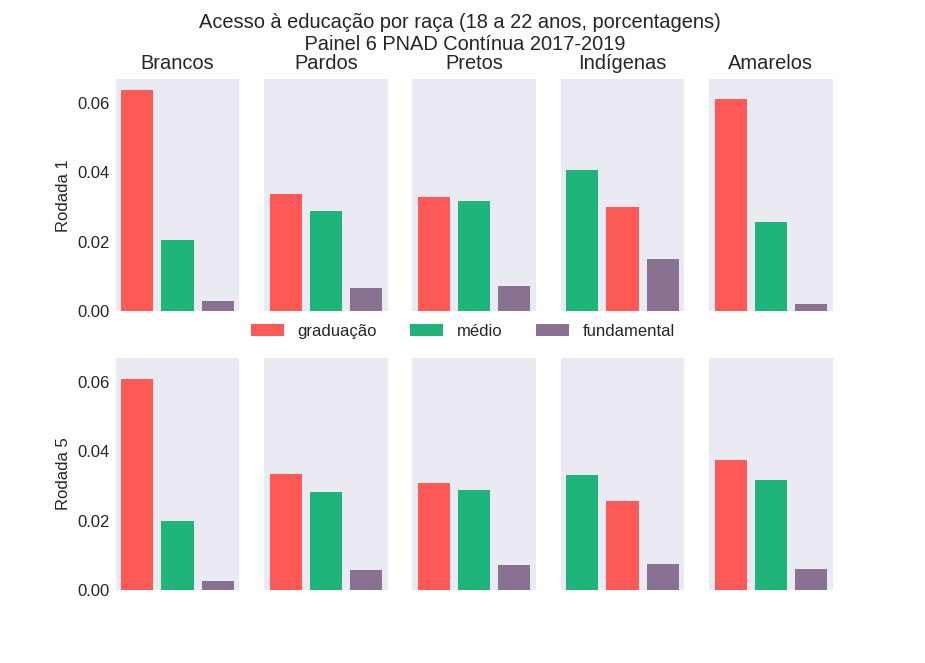

In [248]:
%matplotlib notebook
from matplotlib.patches import Patch
plt.style.use('seaborn-dark')
fig, ax = plt.subplots(2,5, sharey=True)
fig.suptitle('Acesso à educação por raça (18 a 22 anos, porcentagens) \n Painel 6 PNAD Contínua 2017-2019')
colors = ['xkcd:grapefruit', '#1fb57a', '#887191']
# for row in ax:
#     for axis in row:
#         axis.set_xticks(np.arange(1, 4))
ax[0][0].bar(np.arange(1, 4), gera_valores_acesso('branca', 1, 1)[1], color=colors)
ax[0][0].set_title('Brancos')
ax[0][0].set_xticklabels([])
ax[0][0].set_ylabel('Rodada 1')
ax[1][0].bar(np.arange(1, 4), gera_valores_acesso('branca', 1, 5)[1], color=colors)
ax[1][0].set_xticklabels([])
ax[0][1].bar(np.arange(1, 4), gera_valores_acesso('parda', 4, 1)[1], color=colors)
ax[0][1].set_title('Pardos')
ax[0][1].set_xticklabels([])
ax[1][0].set_ylabel('Rodada 5')
ax[1][1].bar(np.arange(1, 4), gera_valores_acesso('parda', 4, 5)[1], color=colors)
ax[1][1].set_xticklabels([])
ax[0][2].bar(np.arange(1, 4), gera_valores_acesso('preta', 2, 1)[1], color=colors)
ax[0][2].set_title('Pretos')
ax[0][2].set_xticklabels([])
ax[1][2].bar(np.arange(1, 4), gera_valores_acesso('preta', 2, 5)[1], color=colors)
ax[1][2].set_xticklabels([])
ax[0][3].bar(np.arange(1, 4), gera_valores_acesso('indígena', 5, 1)[1], color=['#1fb57a', 'xkcd:grapefruit', '#887191'])
ax[0][3].set_title('Indígenas')
ax[0][3].set_xticklabels([])
ax[1][3].bar(np.arange(1, 4), gera_valores_acesso('indígena', 5, 5)[1], color=['#1fb57a', 'xkcd:grapefruit', '#887191'])
ax[1][3].set_xticklabels([])
ax[0][4].bar(np.arange(1, 4), gera_valores_acesso('amarela', 3, 1)[1], color=colors)
ax[0][4].set_title('Amarelos')
ax[0][4].set_xticklabels([])
ax[1][4].bar(np.arange(1, 4), gera_valores_acesso('amarela', 3, 5)[1], color=colors)
ax[1][4].set_xticklabels([])
# fig.autofmt_xdate(rotation=45)
legend_elements = [Patch(facecolor=colors[0], label='graduação'),
                  Patch(facecolor=colors[1], label='médio'),
                  Patch(facecolor=colors[2], label='fundamental')]
leg = fig.legend(handles=legend_elements, loc=10, ncol=3)
plt.subplots_adjust(hspace = 0.2)

Selecionares o grupo de pessoas que na primeira rodada (2017/4) se declaravam brancas e que estão em idade de inserção no ensino superior (estipulamos entre 18 e 22 anos). Considerando este grupo, a variável "ter mudado a declaração de cor para parda, preta ou indígena" (variável independente) tem associação com a variável "estar cursando curso no ensino superior" (variável dependente)?

Passo 1) Selecionar o grupo de pessoas que se declararam brancas em 2017/4 entre 18 e 22 anos

In [88]:
selecao = painel6_filtrado[(painel6_filtrado.Ano == 2017) & (painel6_filtrado.V2010 == 1) 
                           & (painel6_filtrado.V2009 >= 18) & (painel6_filtrado.V2009 <= 22)].keyInd

In [28]:
#total de observações encontradas
selecao.shape[0]

23041

In [29]:
painel6_filtrado.keyInd.unique().shape[0]

510338

In [89]:
df_selecao = painel6_filtrado[painel6_filtrado.keyInd.isin(selecao)]

In [31]:
df_selecao.shape

(53765, 32)

Passo 2) Criar as variáveis de interesse:

In [32]:
mudou_cor = df_selecao.groupby('keyInd')['V2010'].nunique().eq(1).map({True:0, False:1})
mudou_cor

keyInd
110000034.03.06.04.0     1
110000584.08.06.03.0     0
110000620.014.06.02.0    0
110000932.014.06.03.0    0
110001287.05.06.02.0     0
                        ..
530044198.07.06.02.0     0
530044434.01.06.05.0     0
530044434.012.06.06.0    0
530044434.03.06.03.0     0
530051067.09.06.02.0     0
Name: V2010, Length: 12634, dtype: int64

In [33]:
mudou_cor.value_counts()

0    7532
1    5102
Name: V2010, dtype: int64

In [91]:
def ensino_superior(s):
    lista = s.to_list()
    for item in lista:
        if item >= 8:
            return 1
        return 0

In [35]:
ensino_superior = df_selecao.groupby('keyInd').V3003A.apply(ensino_superior)

In [36]:
ensino_superior.value_counts()

0    8997
1    3637
Name: V3003A, dtype: int64

Passo 3) Criando tabela de contingência e aplicando o teste Qui Quadrado para testar se as variáveis são dependentes entre si

In [38]:
pd.crosstab(mudou_cor, ensino_superior, margins=True, margins_name='Total')

V3003A,0,1,Total
V2010,,,
0,5034,2498,7532
1,3963,1139,5102
Total,8997,3637,12634


In [39]:
crosstab = pd.crosstab(mudou_cor, ensino_superior)

In [40]:
stat, p, dof, expected = chi2_contingency(crosstab)

In [41]:
print(expected)

[[5363.73310116 2168.26689884]
 [3633.26689884 1468.73310116]]


In [42]:
prob = 0.995
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

probability=0.995, critical=7.879, stat=173.835
Dependent (reject H0)


A hipótese nula (de que não há associação ou dependência entre as variáveis "mudar a declaração de cor" e "acessar o ensino superior") foi rejeitada. Em seguida realizaremos o teste Chi Quadrado para cada um dos sexos, buscando por diferenças importantes

In [92]:
mudou_cor_masc = df_selecao[df_selecao.V2007 == 1].groupby('keyInd')['V2010'].nunique().eq(1).map({True:0, False:1})
mudou_cor_fem = df_selecao[df_selecao.V2007 == 2].groupby('keyInd')['V2010'].nunique().eq(1).map({True:0, False:1})
ensino_superior_masc = df_selecao[df_selecao.V2007 == 1].groupby('keyInd').V3003A.apply(ensino_superior)
ensino_superior_fem = df_selecao[df_selecao.V2007 == 2].groupby('keyInd').V3003A.apply(ensino_superior)
crosstab_masc = pd.crosstab(mudou_cor_masc, ensino_superior_masc)
crosstab_fem = pd.crosstab(mudou_cor_fem, ensino_superior_fem)

In [93]:
stat, p, dof, expected = chi2_contingency(crosstab_masc)
print(expected)
prob = 0.995
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

[[2883.41192917  953.58807083]
 [1954.58807083  646.41192917]]
probability=0.995, critical=7.879, stat=83.964
Dependent (reject H0)


In [94]:
stat, p, dof, expected = chi2_contingency(crosstab_fem)
print(expected)
prob = 0.995
critical = chi2.ppf(prob, dof)
print('probability=%.3f, critical=%.3f, stat=%.3f' % (prob, critical, stat))
if abs(stat) >= critical:
	print('Dependent (reject H0)')
else:
	print('Independent (fail to reject H0)')

[[2480.22998709 1214.77001291]
 [1678.77001291  822.22998709]]
probability=0.995, critical=7.879, stat=90.649
Dependent (reject H0)
